# Tutoriel YUV

Dans ce tutoriel, nous allons transformer une image au format RGB vers YUV en implémentant une accélération dans la Pynq-Z2. Par la suite, nous pourrons alors échelonner les valeurs des canaux YUV, puis nous convertirons l'image au format RGB pour en visualiser les effets.

## Vitis HLS et Vivado

Pour synthétiser une description matérielle pour un FPGA, nous utilisons Vitis HLS et Vivado. **Ce tutoriel a été réalisé avec la version 2024.2 des outils.**

Il faudra avoir réalisé la synthèse et la création des IP cores, puis réalisé le design pour l'implémentation et la génération des fichiers Bitstream et Hardware Handoff. Ces fichiers seront à placer dans le même dossier que ce notebook.

## Import de libraries et configuration de la Pynq-Z2

Nous importons la librarie $\texttt{pynq}$ qui nous permet d'interagir avec le FPGA. $\texttt{OpenCV}$ nous permettra d'ouvrir une image de manière optimisée, $\texttt{numpy}$ servira à la conversion $8$ bit vers $32$ bits et $\texttt{matplotlib}$ sera utilisé pour afficher l'image de sortie.

In [1]:
from pynq import allocate, PL, Overlay
import cv2
import numpy as np
from matplotlib import pyplot as plt

Utiliser $\texttt{PL.reset()}$ permet de réinitialiser la Pynq-Z2.

In [2]:
PL.reset()

Grâce à nos fichiers $\texttt{.bit}$ et $\texttt{.hwh}$, nous pouvons alors configurer la Pynq-Z2 selon notre design. **Il est important de renommer ces deux fichiers pour qu'ils aient le même nom.**

La classe $\texttt{Overlay}$ configure le FPGA selon le fichier Bitstream donné en argument.

In [3]:
implementation = Overlay("./design_1.bit")

## Référencement des IP cores

En appelant $\texttt{Overlay.ip_dict.keys()}$, nous pouvons regarder les IP cores composant notre design. Par exemple, nous retrouvons les deux IP pour RGB vers YUV et inversement. Il y a également les trois scale et les trois DMA. Le SoC Zynq est également présent.

In [4]:
print(implementation.ip_dict.keys())

dict_keys(['scale_0', 'scale_1', 'scale_2', 'torgb_0', 'toyuv_0', 'axi_dma_0', 'axi_dma_1', 'axi_dma_2', 'processing_system7_0'])


Nous avons alors besoin de référencer ces IP core pour les utiliser par la suite. Il suffit de créer des variables pointant vers les IP cores. Nous pouvons aussi créer des variables pour référencer les DMAs de notre design.

In [5]:
scale_0 = implementation.scale_0
scale_1 = implementation.scale_1
scale_2 = implementation.scale_2

torgb_0 = implementation.torgb_0
toyuv_0 = implementation.toyuv_0

dma_0 = implementation.axi_dma_0
dma_1 = implementation.axi_dma_1
dma_2 = implementation.axi_dma_2

De la même manière, étant donné que nous utilisons des DMAs dans notre design, il est préférable de référencer les canaux d'envoi et de réception. Ces canaux sont utilisés pour les flux de données en AXI Stream.

Pour rappel:
- **AXI Stream** est utilisé pour les données en grande quantité et nécessite un DMA par flux. Il est recommendé d'utiliser cette interface pour les données représentant le son, les images et tout type de flux en direct.
- **AXI Lite** est utilisé pour des données de petite taille. Le CPU se charge d'écrire et de lire des interfaces de l'IP core. Par exemple, pour configurer des variables constantes, il est préférable d'utiliser AXI Lite.

Dans notre design, nous utilisons AXI Stream pour les trois canaux d'entrée et de sortie de l'image en RGB et YUV. Nous utilisons AXI Lite pour configurer les IP core : hauteur et largeur de l'image et paramètre d'échelle pour scale.

In [6]:
dma0_send = dma_0.sendchannel
dma0_recv = dma_0.recvchannel

dma1_send = dma_1.sendchannel
dma1_recv = dma_1.recvchannel

dma2_send = dma_2.sendchannel
dma2_recv = dma_2.recvchannel

## Lecture d'un image

Ici, nous définissons une fonction permettant de lire une image. La bibliothèque d'OpenCV est optimisée en C pour une lecture rapide. Notons qu'il est néanmoins possible d'implémenter notre propre fonction de lecture que vous pouvez tout à fait essayer par vous même en bonus.

In [7]:
def image_read(fname):
    im = cv2.imread(fname, cv2.IMREAD_COLOR)
    if im is None:
        raise ValueError(f"Image at path '{fname}' could not be read.")

    height, width = im.shape[:2]
    B, G, R = cv2.split(im)

    return width, height, R, G, B

In [8]:
width, height, R, G, B = image_read("./input.jpg")

**ATTENTION :** La bibliothèque d'OpenCV lit une image et renvoie ses données au format $8$ bits. Dans notre design, nous avons utilisé $32$ bits, il faut donc assurer la compatibilité entre les deux formats. Pour plus de simplicité, nous convertissons ici nos canaux en $32$ bits avec la librairie $\texttt{numpy}$.

In [9]:
R = R.astype(np.int32)
G = G.astype(np.int32)
B = B.astype(np.int32)

## Lecture et écriture avec AXI Lite

Dans une première partie, nous allons utiliser les interfaces de AXI Lite pour configurer nos IP cores.

Nous écrivons une fonction annexe permettant de retourner l'adresse des variables dans l'IP. En effet, chaque interface AXI Lite ajoutée peut être vue comme une liste en C. Pour lire et écrire des valeurs, il faut pointer vers la bonne adresse.

In [10]:
def get_register_offset(overlay, ip, parameter):
    return overlay.ip_dict[ip]['registers'][parameter]['address_offset']

Pour RGB vers YUV, nous récupérons les adresses de hauteur et de largeur.

In [11]:
WIDTH_ADDR_yuv = get_register_offset(implementation, "toyuv_0", "width")
HEIGHT_ADDR_yuv = get_register_offset(implementation, "toyuv_0", "height")

Pour YUV vers RGB, nous récupérons également les adresses de hauteur et de largeur.

In [12]:
WIDTH_ADDR_rgb = get_register_offset(implementation, "torgb_0", "width")
HEIGHT_ADDR_rgb = get_register_offset(implementation, "torgb_0", "height")

Pour les trois IP cores de scale, nous récupérons l'adresse du facteur de changement d'échelle.

In [13]:
SCALE_Y = get_register_offset(implementation, "scale_0", "scale_factor")
SCALE_U = get_register_offset(implementation, "scale_1", "scale_factor")
SCALE_V = get_register_offset(implementation, "scale_2", "scale_factor")

Nous pouvons alors définir des variables qui permettrons de changer l'échelle des canaux Y, U et V.

In [14]:
scale_y = 2
scale_u = 1
scale_v = 1

Maintenant, nous pouvons écrire la taille de notre image d'entrée dans les interfaces AXI Lite des deux IP RGB vers YUV et inversement.

In [15]:
toyuv_0.write(WIDTH_ADDR_yuv, width)
toyuv_0.write(HEIGHT_ADDR_yuv, height)

In [16]:
torgb_0.write(WIDTH_ADDR_rgb, width)
torgb_0.write(HEIGHT_ADDR_rgb, height)

De même, nous écrivons la taille pour les IP scale ainsi que le facteur souhaité pour chaque canal.

In [17]:
scale_0.write(get_register_offset(implementation, "scale_0", "width"), width)
scale_0.write(get_register_offset(implementation, "scale_0", "height"), height)

scale_1.write(get_register_offset(implementation, "scale_1", "width"), width)
scale_1.write(get_register_offset(implementation, "scale_1", "height"), height)

scale_2.write(get_register_offset(implementation, "scale_0", "width"), width)
scale_2.write(get_register_offset(implementation, "scale_0", "height"), height)

In [18]:
scale_0.write(SCALE_Y, scale_y)
scale_1.write(SCALE_U, scale_u)
scale_2.write(SCALE_V, scale_v)

## Démarrer les IP

Maintenant que nous avons configuré notre Pynq-Z2 et nos IP cores, il faut les démarrer en écrivant dans le registre de contrôle.

De manière synthétique, ce registre se trouve toujours à l'adresse $0$ de l'IP concernée. De plus:
- 0x01 correspond à une exécution singulière où l'IP ne traitera les données qu'une seule fois.
- 0x81 correspond à une exécution en boucle sans fin.

In [19]:
CONTROL_REGISTER = 0x0

In [20]:
torgb_0.write(CONTROL_REGISTER, 0x81)
toyuv_0.write(CONTROL_REGISTER, 0x81)

In [21]:
scale_0.write(CONTROL_REGISTER, 0x81)
scale_1.write(CONTROL_REGISTER, 0x81)
scale_2.write(CONTROL_REGISTER, 0x81)

## Transférer des données avec AXI Stream

Ici, nous allouons de la mémoire pour stocker notre image d'entrée et de sortie. Ceci correspond à la fonction $\texttt{malloc}$ en C. **Il faudra veiller à désallouer la mémoire après utilisation.**

In [22]:
total = width * height

r_in = allocate(shape=(total,), dtype=np.int32)
g_in = allocate(shape=(total,), dtype=np.int32)
b_in = allocate(shape=(total,), dtype=np.int32)

r_out = allocate(shape=(total,), dtype=np.int32)
g_out = allocate(shape=(total,), dtype=np.int32)
b_out = allocate(shape=(total,), dtype=np.int32)

Nous copions les données de l'image lue vers nos nouveaux registres. Il est évident que cela n'est pas optimisé, nous pourrions utiliser une fonction définie dans $\texttt{numpy}$.

In [23]:
for i in range(height):
    for j in range(width):
        r_in[j + width * i] = R[i][j]
        g_in[j + width * i] = G[i][j]
        b_in[j + width * i] = B[i][j]

La fonction annexe ci-dessous permet de transférer six registres dont trois seront lus et trois seront écrits.

In [24]:
def transfer(in0, in1, in2, out0, out1, out2):
    print(in0, in1, in2, out0, out1, out2)
    dma0_send.transfer(in0)
    dma1_send.transfer(in1)
    dma2_send.transfer(in2)
    print("Send done") 
    
    dma0_recv.transfer(out0)
    dma1_recv.transfer(out1)
    dma2_recv.transfer(out2)
    print("Receive done")
    
    dma0_send.wait()   
    print("Send wait 0")
    
    dma1_send.wait()   
    print("Send wait 1") 
    
    dma2_send.wait()   
    print("Send wait 2")
    
    dma0_recv.wait()
    print("Receive wait 0")
    
    dma1_recv.wait()
    print("Receive wait 1")
    
    dma2_recv.wait()
    print("Receive wait 2")

In [25]:
transfer(r_in, g_in, b_in, r_out, g_out, b_out)

[ 0  0  0 ... 19 19 19] [ 0  0  0 ... 45 45 45] [ 0  0  0 ... 70 70 70] [0 0 0 ... 0 0 0] [0 0 0 ... 0 0 0] [0 0 0 ... 0 0 0]
Send done
Receive done
Send wait 0
Send wait 1
Send wait 2
Receive wait 0
Receive wait 1
Receive wait 2


In [26]:
b_out

PynqBuffer([  0,   0,   0, ..., 108, 108, 108])

## Former une nouvelle image de sortie

Lors de la communication avec le FPGA au travers des DMAs pour AXI Stream, les données sont transférées de manière séquentielles sous forme de vecteur en ligne. Alors, les données sont également retournées sous forme de vecteur. Si nous souhaitons afficher l'image de sortie, il est préférable de redimensionner le vecteur sous forme de matrice.

In [27]:
in_image = np.stack((R, G, B), axis=-1)

reshaped_r = r_out.reshape((height, width))
reshaped_g = g_out.reshape((height, width))
reshaped_b = b_out.reshape((height, width))

out_image = np.stack((reshaped_r, reshaped_g, reshaped_b), axis=-1)

Grâce à $\texttt{matplotlib}$, nous pouvons afficher l'image d'origine et de sortie.

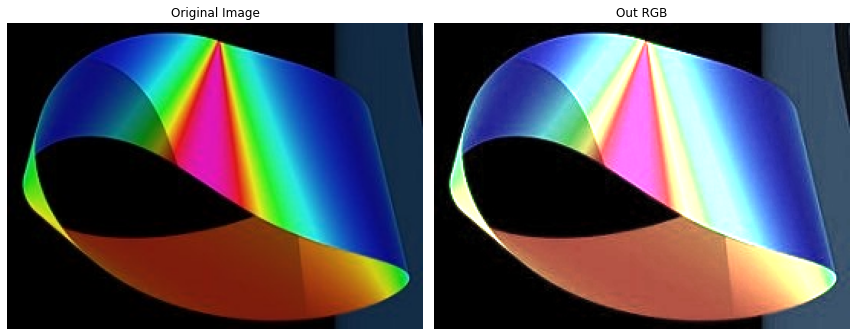

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# original
axs[0].imshow(in_image)
axs[0].set_title("Original Image")
axs[0].axis('off')

# restaured
axs[1].imshow(out_image)
axs[1].set_title("Out RGB")
axs[1].axis('off')

plt.tight_layout()
plt.show()

**ATTENTION :** Ne pas oublier de désallouer la mémoire!

In [29]:
del r_in, g_in, b_in, r_out, g_out, b_out